### Check how many wind events like ours happen in SVB using ERA5 winds

Find wind events where winds blow towards the SE for 4 consecutive hours and wind stress is greater or equal to 0.1 Nm$^{-2}$. U and V wind components at 10 m from the dataset: ERA5 hourly data on single levels from 1979-present.

In [2]:
from __future__ import division
import cmocean as cmo
import datetime as dt
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from xmitgcm import open_mdsdataset
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import xarray as xr
import os
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [54]:
def stick_plot(time, u, v, **kw):
    '''Function by Filipe Fernandes: https://ocefpaf.github.io/python4oceanographers/blog/2014/09/15/stick_plot/'''
    width = kw.pop('width', 0.002)
    headwidth = kw.pop('headwidth', 0)
    headlength = kw.pop('headlength', 0)
    headaxislength = kw.pop('headaxislength', 0)
    angles = kw.pop('angles', 'uv')
    ax = kw.pop('ax', None)
    
    if angles != 'uv':
        raise AssertionError("Stickplot angles must be 'uv' so that"
                             "if *U*==*V* the angle of the arrow on"
                             "the plot is 45 degrees CCW from the *x*-axis.")

    time, u, v = map(np.asanyarray, (time, u, v))
    if not ax:
        fig, ax = plt.subplots()
    
    q = ax.quiver(date2num(time), [[0]*len(time)], u, v,
                  angles='uv', width=width,headwidth=headwidth, 
                  headlength=headlength, headaxislength=headaxislength, linewidth=0.001,
                  **kw)

    ax.axes.get_yaxis().set_visible(False)
    ax.xaxis_date()
    
    return q

def drag_coef_LP81(V10):
    '''Returns the drag coefficient Large and Pond (1981) style.
    V10 is the wind magnitude at 10 m.'''
    Cd = 0.001*(0.49+(0.065*V10))
    return(Cd)

def tau(U10, V10, rho=1.29):
    Umag = np.sqrt(U10**2+V10**2)
    taux,tauy = Umag*U10*drag_coef_LP81(Umag)*rho, Umag*V10*drag_coef_LP81(Umag)*rho
    return(taux,tauy)

### ERA5 file

I downloaded U and V components of wind at 4 pressure levels (1,10,100,500 hPa) for all of 2016 at a similar domain as the one I have in the model.

In [4]:
filename = '/home/sio-kramosmusalem/data/ERA5/adaptor.mars.internal-1655241630.6760662-1783-2-81d37b2d-a46c-4ec6-abb4-6ccf494e5323.nc'
dsw = xr.open_dataset(filename)

Who's there?

In [5]:
dsw

<xarray.Dataset>
Dimensions:    (latitude: 33, longitude: 29, time: 8784)
Coordinates:
  * longitude  (longitude) float32 -121.0 -120.8 -120.5 ... -114.5 -114.2 -114.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 27.5 27.25 27.0
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Data variables:
    u10n       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10n       (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-14 21:22:58 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [7]:
# Load coastline from model output
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/02_SVB_barotropic_output/'
levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta'], levels=levels)

In [8]:
depth = ds.Depth[:]
LAT = ds['YC'][:]
LON = ds['XC'][:]-360
lat = ds.YC[:,0].data
lon = ds.XC[0,:].data-360

Text(0.5, 1.0, '')

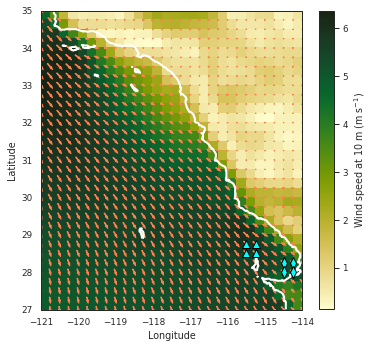

In [9]:
sns.set_context('paper')
sns.set_style('white')
tind = 2000 
spd = np.sqrt(dsw.u10[:,...].mean(axis=0)**2 + dsw.v10[:,...].mean(axis=0)**2)

xa1 = 22#22
xa2 = 23#23
ya1 = 25#25
ya2 = 26#26

xb1 = 26#26
xb2 = 27#27
yb1 = 27#27
yb2 = 28#28

# Plot snapshot
fig, ax = plt.subplots(1,1, figsize=(6,5.5))
pc = ax.pcolormesh(dsw.longitude,dsw.latitude,  spd, cmap=cmo.cm.speed)
plt.colorbar(pc, ax=ax, label=r'Wind speed at 10 m (m s$^{-1}$)')
ax.quiver(dsw.longitude,dsw.latitude,dsw.u10.mean(axis=0),dsw.v10.mean(axis=0), 
          color='coral',linewidths=1,edgecolors='coral', pivot='middle')
ax.contour(lon, lat, depth, levels=[-2,0], colors='w', linewidths=2)
lon_ICDN = [dsw.longitude[xa1], dsw.longitude[xa1], dsw.longitude[xa2], dsw.longitude[xa2]]
lat_ICDN = [dsw.latitude[ya1], dsw.latitude[ya2],dsw.latitude[ya1], dsw.latitude[ya2]]
lon_GROM = [dsw.longitude[xb1],dsw.longitude[xb1],dsw.longitude[xb2],dsw.longitude[xb2]]
lat_GROM = [dsw.latitude[yb1],dsw.latitude[yb2],dsw.latitude[yb1],dsw.latitude[yb2]]
ax.plot(lon_ICDN, lat_ICDN, '^', color='cyan', markeredgecolor='k', markersize=8)
ax.plot(lon_GROM, lat_GROM, 'd', color='cyan', markeredgecolor='k', markersize=8)

ax.set_aspect(1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(str(dsw.time[tind].data))
ax.set_xlim(-121,-114)
ax.set_ylim(27,35)
ax.set_title('')

Hourly time series of U10 and V10 for 2016 

Text(0, 0.5, 'Windswpeed (m s$^{-1}$)')

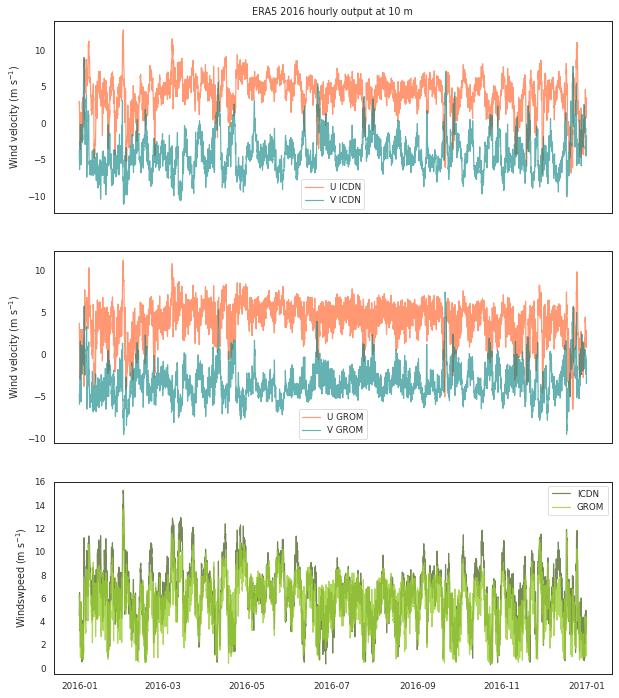

In [10]:
# Timeseries of mean U, V and speed at equivalent ICDN and GROM 
U_ICDN = (dsw.u10[:,ya1:ya2+1,xa1:xa2+1].mean(dim='latitude')).mean(dim='longitude')
V_ICDN = (dsw.v10[:,ya1:ya2+1,xa1:xa2+1].mean(dim='latitude')).mean(dim='longitude')
speed_ICDN = np.sqrt((dsw.u10[:,ya1:ya2+1,xa1:xa2+1]**2+dsw.v10[:,ya1:ya2+1,xa1:xa2+1]**2))
SPD_ICDN = (speed_ICDN.mean(dim='latitude')).mean(dim='longitude')

U_GROM = (dsw.u10[:,yb1:yb2+1,xb1:xb2+1].mean(dim='latitude')).mean(dim='longitude')
V_GROM = (dsw.v10[:,yb1:yb2+1,xb1:xb2+1].mean(dim='latitude')).mean(dim='longitude')
speed_GROM = np.sqrt((dsw.u10[:,yb1:yb2+1,xb1:xb2+1]**2+dsw.v10[:,yb1:yb2+1,xb1:xb2+1]**2))
SPD_GROM = (speed_GROM.mean(dim='latitude')).mean(dim='longitude')

# Plot timeseries
sns.set_style('white')
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12), sharex=True,)
ax1.plot(dsw.time, U_ICDN, label='U ICDN', color='coral', alpha=0.8)
ax1.plot(dsw.time, V_ICDN, label='V ICDN', color='teal', alpha=0.6)
ax1.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax1.legend()
ax1.set_title('ERA5 2016 hourly output at 10 m')

ax2.plot(dsw.time, U_GROM, label='U GROM', color='coral', alpha=0.8)
ax2.plot(dsw.time, V_GROM, label='V GROM', color='teal', alpha=0.6)
ax2.set_ylabel(r'Wind velocity (m s$^{-1}$)')
ax2.legend()

ax3.plot(dsw.time, SPD_ICDN, color='darkolivegreen', alpha=0.8, label='ICDN')
ax3.plot(dsw.time, SPD_GROM, color='yellowgreen', alpha=0.8, label='GROM')
ax3.legend()
ax3.set_ylabel(r'Windswpeed (m s$^{-1}$)')


Text(0.5, 1.0, 'ICDN')

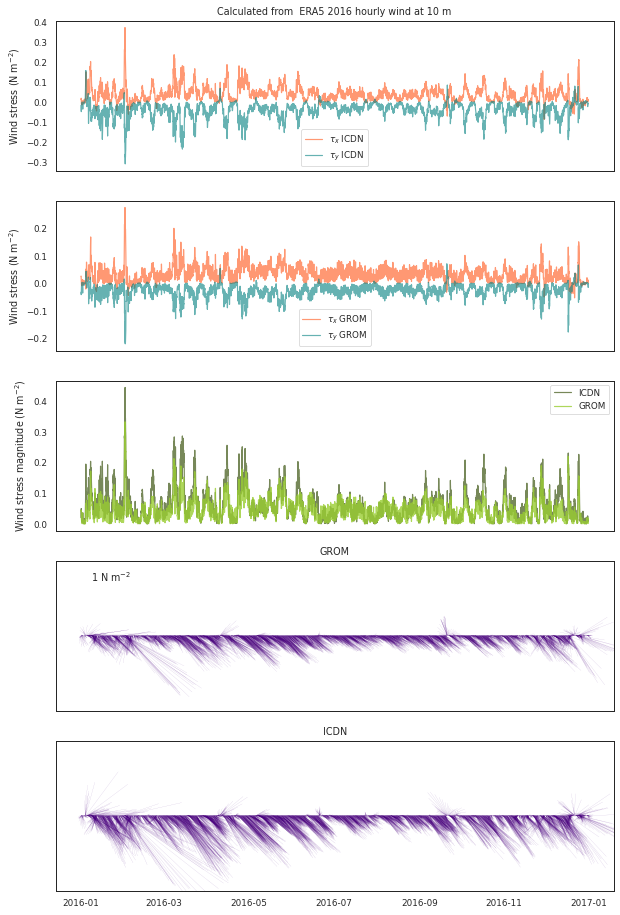

In [11]:
# Time series of mean taux and tauy and speed at equivalent ICDN and GROM 

tx_GN, ty_GN = tau(U_GROM,V_GROM)
tx_IC, ty_IC = tau(U_ICDN,V_ICDN)

magTau_GN = np.sqrt((tx_GN**2+ty_GN**2))
magTau_IC = np.sqrt((tx_IC**2+ty_IC**2))

dirTau_GN = np.rad2deg(np.arctan(ty_GN/tx_GN))
dirTau_IC = np.rad2deg(np.arctan(ty_IC/tx_IC))

# Plot timeseries
sns.set_style('white')
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(10,16), sharex=True,)
ax1.plot(dsw.time, tx_IC, label=r'$\tau_x$ ICDN', color='coral', alpha=0.8)
ax1.plot(dsw.time, ty_IC, label=r'$\tau_y$ ICDN', color='teal', alpha=0.6)
ax1.set_ylabel(r'Wind stress (N m$^{-2}$)')
ax1.legend()
ax1.set_title('Calculated from  ERA5 2016 hourly wind at 10 m')

ax2.plot(dsw.time, tx_GN, label=r'$\tau_x$ GROM', color='coral', alpha=0.8)
ax2.plot(dsw.time, ty_GN, label=r'$\tau_y$ GROM', color='teal', alpha=0.6)
ax2.set_ylabel(r'Wind stress (N m$^{-2}$)')
ax2.legend()

ax3.plot(dsw.time, magTau_IC, color='darkolivegreen', alpha=0.8, label='ICDN')
ax3.plot(dsw.time, magTau_GN, color='yellowgreen', alpha=0.8, label='GROM')
ax3.legend()
ax3.set_ylabel(r'Wind stress magnitude (N m$^{-2}$)')

q1 = stick_plot(dsw.time, tx_GN, ty_GN, ax=ax4, width=0.0001, scale=2, color='indigo')
q2 = stick_plot(dsw.time, tx_IC, ty_IC, ax=ax5, width=0.0001, scale=2, color='indigo')

ref = 1
qk = ax4.quiverkey(q1, 0.1, 0.8, ref,
                      "%s N m$^{-2}$" % ref,
                      labelpos='N', coordinates='axes')
ax4.set_title('GROM')
ax5.set_title('ICDN')



(16801.0, 17166.958333333332)

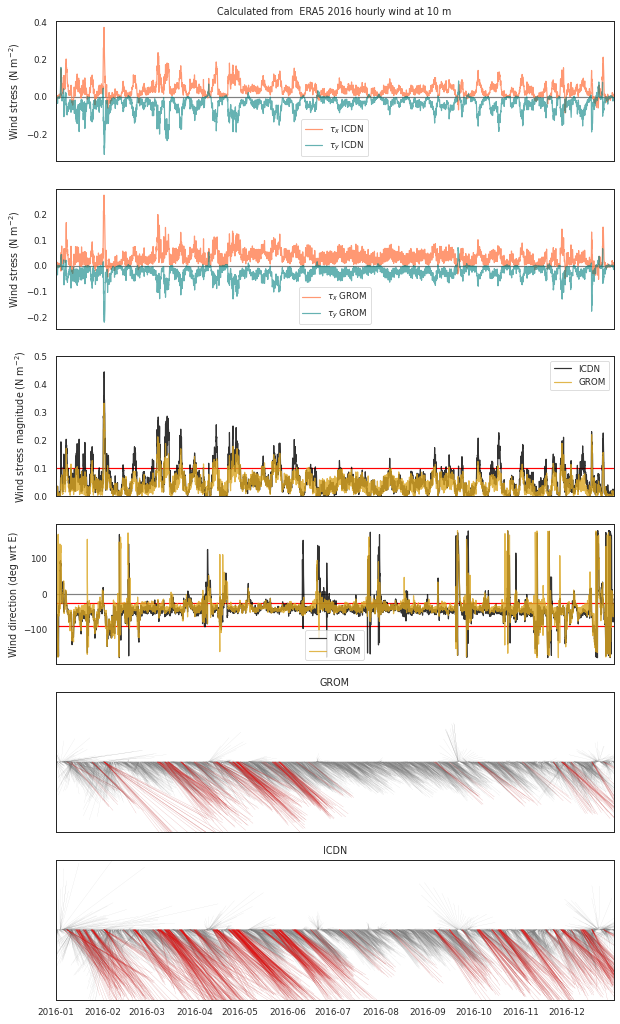

In [12]:
# Time series of mean taux and tauy and speed at equivalent ICDN and GROM 

tx_GN, ty_GN = tau(U_GROM,V_GROM)
tx_IC, ty_IC = tau(U_ICDN,V_ICDN)

magTau_GN = np.sqrt((tx_GN**2+ty_GN**2))
magTau_IC = np.sqrt((tx_IC**2+ty_IC**2))

dirTau_GN = np.rad2deg(np.arctan2(ty_GN,tx_GN))
dirTau_IC = np.rad2deg(np.arctan2(ty_IC,tx_IC))

# Plot timeseries
sns.set_style('white')
fig, (ax1, ax2, ax3, ax6, ax4, ax5) = plt.subplots(6,1, figsize=(10,18), sharex=True,)
ax1.axhline(0, color='0.5')
ax1.plot(dsw.time, tx_IC, label=r'$\tau_x$ ICDN', color='coral', alpha=0.8)
ax1.plot(dsw.time, ty_IC, label=r'$\tau_y$ ICDN', color='teal', alpha=0.6)
ax1.set_ylabel(r'Wind stress (N m$^{-2}$)')
ax1.legend()
ax1.set_title('Calculated from  ERA5 2016 hourly wind at 10 m')

ax2.axhline(0, color='0.5')
ax2.plot(dsw.time, tx_GN, label=r'$\tau_x$ GROM', color='coral', alpha=0.8)
ax2.plot(dsw.time, ty_GN, label=r'$\tau_y$ GROM', color='teal', alpha=0.6)
ax2.set_ylabel(r'Wind stress (N m$^{-2}$)')
ax2.legend()

ax3.axhline(0.1, color='r')
ax3.plot(dsw.time, magTau_IC, color='black', alpha=0.8, label='ICDN')
ax3.plot(dsw.time, magTau_GN, color='goldenrod', alpha=0.8, label='GROM')
ax3.legend()
ax3.set_ylabel(r'Wind stress magnitude (N m$^{-2}$)')
ax3.set_ylim(0,0.5)

ax6.axhline(0, color='0.5')
ax6.axhline(-25, color='r')
ax6.axhline(-90, color='r')
ax6.plot(dsw.time, dirTau_IC, color='black', alpha=0.8, label='ICDN')
ax6.plot(dsw.time, dirTau_GN, color='goldenrod', alpha=0.8, label='GROM')
ax6.legend()
ax6.set_ylabel(r'Wind direction (deg wrt E)')

temp_IC = np.ma.masked_less(magTau_IC, 0.1)
taumask_IC = np.ma.getmask(temp_IC)

temp_GN = np.ma.masked_less(magTau_GN, 0.1)
taumask_GN = np.ma.getmask(temp_GN)

temp2_IC = np.ma.masked_greater(dirTau_IC, -25)
temp3_IC = np.ma.masked_less(temp2_IC, -90)
dirmask_IC = np.ma.getmask(temp3_IC)
tx_masked_IC = np.ma.masked_array(np.ma.masked_array(tx_IC, mask=taumask_IC), mask=dirmask_IC)
ty_masked_IC = np.ma.masked_array(np.ma.masked_array(ty_IC, mask=taumask_IC), mask=dirmask_IC)

temp2_GN = np.ma.masked_greater(dirTau_GN, -25)
temp3_GN = np.ma.masked_less(temp2_GN, -90)
dirmask_GN = np.ma.getmask(temp3_GN)
tx_masked_GN = np.ma.masked_array(np.ma.masked_array(tx_GN, mask=taumask_GN), mask=dirmask_GN)
ty_masked_GN = np.ma.masked_array(np.ma.masked_array(ty_GN, mask=taumask_GN), mask=dirmask_GN)

q1 = stick_plot(dsw.time, tx_GN, ty_GN, ax=ax4, width=0.0001, scale=1, color='grey')
q2 = stick_plot(dsw.time, tx_masked_GN, ty_masked_GN, ax=ax4, width=0.0001, scale=1, color='red')

q3 = stick_plot(dsw.time, tx_IC, ty_IC, ax=ax5, width=0.0001, scale=1, color='grey')
q4 = stick_plot(dsw.time, tx_masked_IC, ty_masked_IC, ax=ax5, width=0.0001, scale=1, color='red')

ax4.set_title('GROM')
ax5.set_title('ICDN')
ax5.set_xlim(dsw.time[0],dsw.time[-1])

(17101.0, 17131.0)

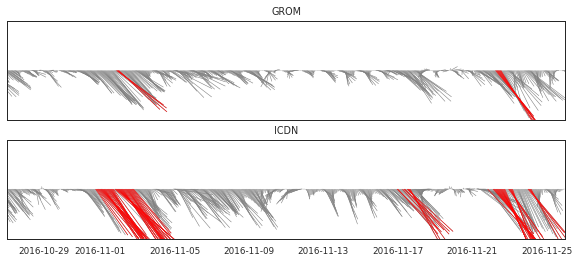

In [51]:
# Time series of mean taux and tauy and speed at equivalent ICDN and GROM 


# Plot timeseries
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True,)

q1 = stick_plot(dsw.time, tx_GN, ty_GN, ax=ax1, width=0.001, scale=1, color='grey')
q2 = stick_plot(dsw.time, tx_masked_GN, ty_masked_GN, ax=ax1, width=0.001, scale=1, color='red')

q3 = stick_plot(dsw.time, tx_IC, ty_IC, ax=ax2, width=0.001, scale=1, color='grey')
q4 = stick_plot(dsw.time, tx_masked_IC, ty_masked_IC, ax=ax2, width=0.001, scale=1, color='red')

ax1.set_title('GROM')
ax2.set_title('ICDN')
ax1.set_xlim(dsw.time[720*10],dsw.time[720*11])

In [14]:
indices = []
for tt,T_hr in zip(range(len(dsw.time)), tx_masked_GN.mask):
    if T_hr == False:
        indices.append(tt)
        
indices2 = []
for tt,T_hr in zip(range(len(dsw.time)), tx_masked_IC.mask):
    if T_hr == False:
        indices2.append(tt)

In [15]:
events = []
ind_indices = []
for ii, ind in zip(range(len(indices)-1),indices[:-1]):
    if ind+1 == indices[ii+1]: 
        continue
    else:
        events.append(ind)
        ind_indices.append(ii)
        
events2 = []
ind_indices2 = []
for ii, ind in zip(range(len(indices2)-1),indices2[:-1]):
    if ind+1 == indices2[ii+1]: 
        continue
    else:
        events2.append(ind)
        ind_indices2.append(ii)

In [16]:
events

[177,
 242,
 244,
 334,
 339,
 566,
 576,
 777,
 1604,
 1606,
 1619,
 1638,
 1644,
 1655,
 1703,
 1708,
 1722,
 1733,
 1757,
 1781,
 1956,
 1975,
 1982,
 1993,
 2173,
 2188,
 2209,
 2328,
 2474,
 2498,
 2521,
 2525,
 2529,
 2536,
 2541,
 2543,
 2712,
 2739,
 2775,
 2779,
 2801,
 2810,
 2834,
 2849,
 2867,
 2883,
 2908,
 3241,
 3262,
 3267,
 3288,
 3413,
 3435,
 3442,
 3458,
 3479,
 3491,
 3505,
 3534,
 3792,
 3959,
 3983,
 5952,
 5977,
 6191,
 6651,
 6962,
 7344,
 7837,
 7954,
 7977,
 7984,
 7997,
 8112,
 8444,
 8613]

In [17]:
print(len(indices))
print(len(indices2))

413
1368


In [18]:
print(len(events))
print(len(events2))

76
119


In [19]:
np.array(ind_indices[1:])-np.array(ind_indices[:-1])

array([ 2,  1,  1,  1,  1,  7, 26, 11,  1,  6,  8,  1,  3,  1,  1,  7,  9,
        7, 15,  1, 11,  5,  3,  3,  6,  3,  2,  4,  6,  5,  1,  2,  6,  3,
        1,  1, 11,  1,  2, 20,  2,  5, 10, 17, 10,  5,  2,  1,  1,  3,  9,
        9,  1, 13,  2,  1,  6, 23,  3,  1,  2,  3,  4,  2, 10,  2,  4,  8,
        1, 17,  1,  5,  7, 10,  1])

In [20]:
np.mean(np.array(ind_indices[1:])-np.array(ind_indices[:-1]))

5.426666666666667

In [21]:
np.std(np.array(ind_indices[1:])-np.array(ind_indices[:-1]))

5.396723285681991

In [22]:
vals,counts = np.unique((np.array(ind_indices[1:])-np.array(ind_indices[:-1])), return_counts=True)
index = np.argmax(counts)
print(vals[index])

1


In [23]:
np.array(ind_indices2[1:])-np.array(ind_indices2[:-1])

array([18,  1,  2,  7, 21,  1,  3,  2, 14, 14,  7,  7, 33,  5,  1,  2, 29,
        6,  5,  5, 40,  2,  1,  2,  3,  2,  5, 15, 18, 34,  2,  1, 79,  4,
        1, 46,  4,  2,  4,  1,  7, 15,  8,  1, 79,  8, 28,  7, 55, 60,  1,
        2,  6, 17,  3, 15, 40, 17, 40,  3,  8, 40,  2,  4,  1,  7,  2,  1,
        2,  9,  1,  1,  2,  7, 31,  3,  2,  3, 18,  6,  2, 41,  8,  4, 10,
        4,  1,  2,  2, 52, 24, 25,  2,  1,  2,  5,  1, 16,  6,  5,  1,  4,
        9, 16,  4,  9,  7,  2,  7,  2,  2,  8, 27,  1,  3,  7, 21,  2])

In [24]:
np.mean(np.array(ind_indices2[1:])-np.array(ind_indices2[:-1]))

11.491525423728813

In [25]:
np.std(np.array(ind_indices2[1:])-np.array(ind_indices2[:-1]))

15.66208082086107

In [26]:
vals2,counts2 = np.unique((np.array(ind_indices2[1:])-np.array(ind_indices2[:-1])), return_counts=True)
index2 = np.argmax(counts2)
print(vals2[index2])

2


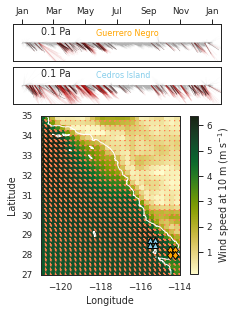

In [56]:
sns.set_style('white')

fig = plt.figure(figsize=(7.48/2,9.2/2))
gs = gridspec.GridSpec(2,1, height_ratios=[0.5,1], hspace=0.1)
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0],hspace=0.15)

ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])
ax3 = fig.add_subplot(gs[1])

ax2.set_xticks([])
ax1.xaxis.set_ticks_position("top")

q1 = stick_plot(dsw.time, tx_GN, ty_GN, ax=ax1, width=0.0001, scale=2, color='0.7')
q2 = stick_plot(dsw.time, tx_masked_GN, ty_masked_GN, ax=ax1, width=0.0001, scale=2, color='red')
q5 = stick_plot(dsw.time[events], tx_masked_GN[events], ty_masked_GN[events],
                ax=ax1, width=0.00075, scale=2, color='k')
monthFmt = mdates.DateFormatter('%b')
ax1.xaxis.set_major_formatter(monthFmt)
q3 = stick_plot(dsw.time, tx_IC, ty_IC, ax=ax2, width=0.0001, scale=2, color='0.7')
q4 = stick_plot(dsw.time, tx_masked_IC, ty_masked_IC, ax=ax2, width=0.0001, scale=2, color='red')
q6 = stick_plot(dsw.time[events2], tx_masked_IC[events2], ty_masked_IC[events2],
                ax=ax2, width=0.00075, scale=2, color='k')

ax1.text(0.4,0.7,'Guerrero Negro', transform=ax1.transAxes, color='orange', fontsize=8)
ax2.text(0.4,0.7,'Cedros Island', transform=ax2.transAxes, color='skyblue',fontsize=8)

#ax1.set_ylabel('Pa', labelpad=0)
#ax2.set_ylabel('Pa', labelpad=0)
#ax1.tick_params(axis='y', which='major', pad=0)
#ax2.tick_params(axis='y', which='major', pad=0)

ref = 0.1
qk1 = ax1.quiverkey(q5, 0.1, 0.8, ref,
                    "%s Pa" % ref,
                    labelpos='E', coordinates='axes')

qk2 = ax2.quiverkey(q6, 0.1, 0.8, ref,
                    "%s Pa" % ref,
                    labelpos='E', coordinates='axes')

sns.set_context('paper')
sns.set_style('white')
tind = 2000 
spd = np.sqrt(dsw.u10[:,...].mean(axis=0)**2 + dsw.v10[:,...].mean(axis=0)**2)

xa1 = 22#22
xa2 = 23#23
ya1 = 25#25
ya2 = 26#26

xb1 = 26#26
xb2 = 27#27
yb1 = 27#27
yb2 = 28#28

# Plot snapshot
pc = ax3.pcolormesh(dsw.longitude,dsw.latitude,  spd, cmap=cmo.cm.speed)
plt.colorbar(pc, ax=ax3, label=r'Wind speed at 10 m (m s$^{-1}$)')
ax3.quiver(dsw.longitude,dsw.latitude,dsw.u10.mean(axis=0),dsw.v10.mean(axis=0), 
          color='coral',linewidths=1,edgecolors='coral', pivot='middle')
ax3.contour(lon, lat, depth, levels=[-2,0], colors='w', linewidths=1)
lon_ICDN = [dsw.longitude[xa1], dsw.longitude[xa1], dsw.longitude[xa2], dsw.longitude[xa2]]
lat_ICDN = [dsw.latitude[ya1], dsw.latitude[ya2],dsw.latitude[ya1], dsw.latitude[ya2]]
lon_GROM = [dsw.longitude[xb1],dsw.longitude[xb1],dsw.longitude[xb2],dsw.longitude[xb2]]
lat_GROM = [dsw.latitude[yb1],dsw.latitude[yb2],dsw.latitude[yb1],dsw.latitude[yb2]]
ax3.plot(lon_ICDN, lat_ICDN, '^', color='skyblue', markeredgecolor='k', markersize=6)
ax3.plot(lon_GROM, lat_GROM, 'd', color='orange', markeredgecolor='k', markersize=6)

ax3.set_aspect(1)
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title(str(dsw.time[tind].data))
ax3.set_xlim(-121,-114)
ax3.set_ylim(27,35)
ax3.set_title('')
plt.savefig('wind_events.png', dpi=500, bbox_inches='tight')

#### 